--- 1. BUILDING SUPER STATS (This takes RAM/Time) ---


Streaming Population Data: 175000it [00:12, 13770.16it/s]


--- 2. PREPARING TRAINING SET ---


Extracting: 100%|██████████| 175000/175000 [00:26<00:00, 6544.51it/s]


--- 3. TRAINING MODEL ---

=== VALIDATION PERFORMANCE ===
Validation MSE: 2.8425


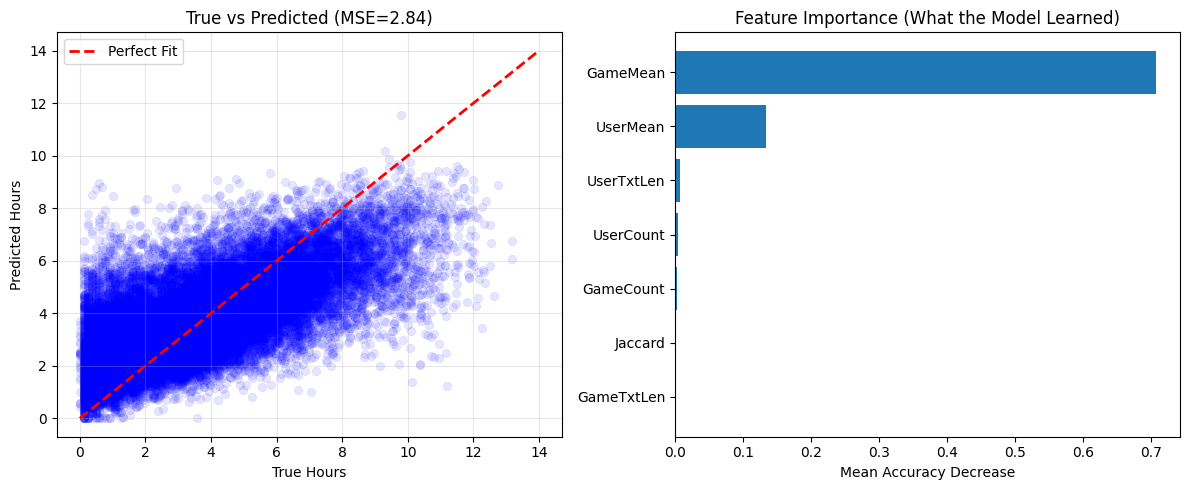


=== MODEL CONFIGURATION (Hyperparameters) ===
categorical_features: from_dtype
early_stopping: auto
l2_regularization: 1.0
learning_rate: 0.05
loss: squared_error
max_bins: 255
max_features: 1.0
max_iter: 300
max_leaf_nodes: 63
min_samples_leaf: 20
monotonic_cst: [1, 0, 1, 1, 0, 1, 1]
n_iter_no_change: 10
random_state: 42
scoring: loss
tol: 1e-07
validation_fraction: 0.1
verbose: 0
warm_start: False

=== LEARNED LOGIC (Feature Importance) ===
GameMean: 0.7067
UserMean: 0.1333
UserTxtLen: 0.0067
UserCount: 0.0041
GameCount: 0.0032
Jaccard: 0.0021
GameTxtLen: 0.0003

--- GENERATING SUBMISSION ---


Extracting: 100%|██████████| 10000/10000 [00:01<00:00, 5895.14it/s]


DONE. Saved 'predictions_Hours.csv'


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import gzip
import matplotlib.pyplot as plt
import seaborn as sns

# =========================================================
# 1. HELPER FUNCTIONS
# =========================================================
def compute_jaccard(u, g, user_games, game_users):
    target_users = game_users.get(g, set())
    if not target_users: return 0.0
    history = user_games.get(u, set())
    if not history: return 0.0
    
    check_limit = 20 
    count = 0
    max_sim = 0.0
    
    for h_g in history:
        if h_g == g: continue 
        h_users = game_users.get(h_g, set())
        if not h_users: continue
        
        inter = len(target_users.intersection(h_users))
        if inter == 0: continue
        sim = inter / (len(target_users) + len(h_users) - inter)
        if sim > max_sim: max_sim = sim
        
        count += 1
        if count >= check_limit: break
    return max_sim

def extract_super_features(df, u_sums, u_counts, u_txt_sums, g_sums, g_counts, g_txt_sums, 
                           global_mean, user_games, game_users):
    features = []
    
    # We iterate over the dataframe rows
    iterator = tqdm(zip(df['userID'], df['gameID']), total=len(df), desc="Extracting")
    
    for u, g in iterator:
        # Retrieve User Super Stats
        if u in u_sums:
            cnt = u_counts[u]
            u_mean = u_sums[u] / cnt
            u_txt = u_txt_sums[u] / cnt
        else:
            u_mean, cnt, u_txt = global_mean, 0, 0
            
        # Retrieve Game Super Stats
        if g in g_sums:
            g_cnt = g_counts[g]
            g_mean = g_sums[g] / g_cnt
            g_txt = g_txt_sums[g] / g_cnt
        else:
            g_mean, g_cnt, g_txt = global_mean, 0, 0
        
        # Interaction
        jac = compute_jaccard(u, g, user_games, game_users)
        
        features.append([u_mean, cnt, u_txt, g_mean, g_cnt, g_txt, jac])
        
    return np.array(features)

def readJSON(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)

# =========================================================
# 2. DATA LOAD & SUPER STATS BUILD (CSV VERSION)
# =========================================================
print("--- 1. BUILDING SUPER STATS FROM CSV ---")

u_sums, u_counts, u_txt_sums = {}, {}, {}
g_sums, g_counts, g_txt_sums = {}, {}, {}

# REPLACE WITH YOUR ACTUAL BIG CSV FILENAME
FILENAME = "your_big_data.csv" 

# Pandas handles the streaming automatically with 'chunksize'
# This returns an iterator of DataFrames, so we don't need to manual append lines
chunk_iterator = pd.read_csv(FILENAME, chunksize=100000)

for df_chunk in tqdm(chunk_iterator, desc="Streaming CSV Data"):
    
    # 1. Ensure columns are named correctly (Optional, depending on your CSV)
    # df_chunk = df_chunk.rename(columns={'user_id': 'userID', 'product_id': 'gameID', ...})
    
    # 2. Pre-calc text length for this chunk
    if 'text' in df_chunk.columns:
        # Fill NaN text with empty string
        txt_lens = np.log1p(df_chunk['text'].fillna('').astype(str).apply(len))
    else:
        txt_lens = np.zeros(len(df_chunk))
    
    # 3. Update User Stats
    # zip is fast enough for iteration within the chunk
    for u, h, t in zip(df_chunk['userID'], df_chunk['hours_transformed'], txt_lens):
        u_sums[u] = u_sums.get(u, 0) + h
        u_counts[u] = u_counts.get(u, 0) + 1
        u_txt_sums[u] = u_txt_sums.get(u, 0) + t
        
    # 4. Update Game Stats
    for g, h, t in zip(df_chunk['gameID'], df_chunk['hours_transformed'], txt_lens):
        g_sums[g] = g_sums.get(g, 0) + h
        g_counts[g] = g_counts.get(g, 0) + 1
        g_txt_sums[g] = g_txt_sums.get(g, 0) + t

# Calculate Global Mean
total_hours = sum(u_sums.values())
total_interactions = sum(u_counts.values())
global_mean = total_hours / total_interactions if total_interactions > 0 else 0

print(f"Global Mean from CSV: {global_mean:.4f}")

# =========================================================
# 3. PREPARE TRAINING DATA
# =========================================================
print("--- 2. PREPARING TRAINING SET ---")
df_train_full = pd.DataFrame(list(readJSON("train.json.gz")))

# Build Jaccard Maps (Local context)
user_games = df_train_full.groupby('userID')['gameID'].apply(set).to_dict()
game_users = df_train_full.groupby('gameID')['userID'].apply(set).to_dict()

# Extract Features
X_full = extract_super_features(df_train_full, u_sums, u_counts, u_txt_sums, 
                                g_sums, g_counts, g_txt_sums, global_mean, 
                                user_games, game_users)
y_full = df_train_full['hours_transformed'].values

# Split for Validation
X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

# =========================================================
# 4. TRAIN MODEL
# =========================================================
print("--- 3. TRAINING MODEL ---")
feature_names = ['UserMean', 'UserCount', 'UserTxtLen', 'GameMean', 'GameCount', 'GameTxtLen', 'Jaccard']

model = HistGradientBoostingRegressor(
    max_iter=300,
    learning_rate=0.05,
    max_leaf_nodes=63,
    l2_regularization=1.0,
    monotonic_cst=[1, 0, 1, 1, 0, 1, 1], # [UM(+), UC(0), UT(+), GM(+), GC(0), GT(+), Jac(+)]
    random_state=42
)

model.fit(X_train, y_train)

# =========================================================
# 5. PERFORMANCE ANALYSIS
# =========================================================
print("\n=== VALIDATION PERFORMANCE ===")
preds = model.predict(X_val)
preds = np.clip(preds, 0, None)
mse = mean_squared_error(y_val, preds)
print(f"Validation MSE: {mse:.4f}")

# --- PLOT 1: True vs Pred ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_val, y=preds, alpha=0.1, color='blue', edgecolor=None)
plt.plot([0, 14], [0, 14], 'r--', linewidth=2, label='Perfect Fit')
plt.title(f"True vs Predicted (MSE={mse:.2f})")
plt.xlabel("True Hours")
plt.ylabel("Predicted Hours")
plt.legend()
plt.grid(True, alpha=0.3)

# --- PLOT 2: Feature Importance ---
result = permutation_importance(model, X_val, y_val, n_repeats=5, random_state=42)
sorted_idx = result.importances_mean.argsort()

plt.subplot(1, 2, 2)
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (What the Model Learned)")
plt.xlabel("Mean Accuracy Decrease")
plt.tight_layout()
plt.show()

# =========================================================
# 6. DETAILED PARAMETER LIST
# =========================================================
print("\n=== MODEL CONFIGURATION (Hyperparameters) ===")
params = model.get_params()
for k, v in params.items():
    if v is not None:
        print(f"{k}: {v}")

print("\n=== LEARNED LOGIC (Feature Importance) ===")
# Print the actual values for clarity
for i in sorted_idx[::-1]:
    print(f"{feature_names[i]}: {result.importances_mean[i]:.4f}")

# =========================================================
# 7. GENERATE SUBMISSION
# =========================================================
try:
    print("\n--- GENERATING SUBMISSION ---")
    pairs = pd.read_csv("pairs_Hours.csv")
    X_test = extract_super_features(pairs, u_sums, u_counts, u_txt_sums, 
                                    g_sums, g_counts, g_txt_sums, global_mean, 
                                    user_games, game_users)
    
    p_final = model.predict(X_test)
    p_final = np.clip(p_final, 0, None)
    
    with open("predictions_Hours.csv", 'w') as f:
        f.write("userID,gameID,prediction\n")
        for i, row in pairs.iterrows():
            f.write(f"{row['userID']},{row['gameID']},{p_final[i]}\n")
            
    print("DONE. Saved 'predictions_Hours.csv'")
except Exception as e:
    print(f"Error generating submission: {e}")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import gzip
import random
import itertools

# =========================================================
# 1. SETUP & DATA LOADING
# =========================================================
def readJSON(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)

def split_train_data(df, test_size=0.2, min_user_games=2, min_game_users=2, random_state=42):
    """
    Split data ensuring all users and items appear in BOTH train and validation to mimic test data.
    
    Parameters:
    -----------
    df : DataFrame 
        pandas DataFramewith columns ['userID','gameID', 'hours_transformed']
    test_size : float
        proportion of data for validation
    min_user_games : int
        min number of games per user to keep in training
    min_game_users : int
        min number of users per game to keep in training
    random_state : int
        for reproducibility

    Returns:
    --------
    train_df, val_df : DataFrames
    """
    # Set random seed
    np.random.seed(random_state)
    
    # Step 1: Filter users and games with enough interactions (Data Cleaning)
    # We iteratively filter until convergence to ensure constraints are met
    print("Filtering data for minimum interactions...")
    temp_df = df.copy()
    
    # Simple one-pass filter (iterative is better but this is usually sufficient for large sparse data)
    user_counts = temp_df['userID'].value_counts()
    valid_users = user_counts[user_counts >= min_user_games].index
    temp_df = temp_df[temp_df['userID'].isin(valid_users)]
    
    game_counts = temp_df['gameID'].value_counts()
    valid_games = game_counts[game_counts >= min_game_users].index
    temp_df = temp_df[temp_df['gameID'].isin(valid_games)]
    
    print(f"Data filtered. Original: {len(df)}, Filtered: {len(temp_df)}")
    
    # Step 2: Group by user to ensure user split
    # We will build a boolean mask for the training set
    # True = Train, False = Validation
    train_mask = np.ones(len(temp_df), dtype=bool)
    
    # Reset index to allow easy indexing
    temp_df = temp_df.reset_index(drop=True)
    
    grouped = temp_df.groupby('userID')
    
    val_indices_list = []
    
    print("Splitting data by user...")
    for user, group in grouped:
        n_samples = len(group)
        # Calculate how many to validate
        n_val = int(n_samples * test_size)
        
        # Constraint: Ensure min_user_games stay in training
        if n_samples - n_val < min_user_games:
            n_val = n_samples - min_user_games
            
        if n_val > 0:
            # Randomly select indices for validation
            val_idx = np.random.choice(group.index, n_val, replace=False)
            val_indices_list.extend(val_idx)
            
    # Apply split mask
    train_mask[val_indices_list] = False
    
    train_df = temp_df[train_mask].copy()
    val_df = temp_df[~train_mask].copy()
    
    # Step 3 & 4: Check for Item Cold-Start in Validation
    # (Items that ended up ONLY in validation)
    train_items = set(train_df['gameID'].unique())
    val_items = set(val_df['gameID'].unique())
    
    # Items present in validation but MISSING from training
    cold_start_items = val_items - train_items
    
    if len(cold_start_items) > 0:
        print(f"Warning: {len(cold_start_items)} games appear in Validation but not Training. Moving them back to Train.")
        
        # Identify rows in validation that contain these cold-start items
        rows_to_move_mask = val_df['gameID'].isin(cold_start_items)
        rows_to_move = val_df[rows_to_move_mask]
        
        # Move them to training
        train_df = pd.concat([train_df, rows_to_move], ignore_index=True)
        val_df = val_df[~rows_to_move_mask].copy()
        
    # Step 5: Final Verification
    final_train_users = set(train_df['userID'].unique())
    final_val_users = set(val_df['userID'].unique())
    final_train_items = set(train_df['gameID'].unique())
    final_val_items = set(val_df['gameID'].unique())
    
    # Assertions
    if not final_val_users.issubset(final_train_users):
        print("Warning: Validation has users not in Train (Should not happen with user-group split).")
        
    if not final_val_items.issubset(final_train_items):
        print("Warning: Validation has items not in Train (Logic error in Step 4).")
        
    # Check for pair overlap
    train_pairs = set(zip(train_df['userID'], train_df['gameID']))
    val_pairs = set(zip(val_df['userID'], val_df['gameID']))
    overlap = train_pairs.intersection(val_pairs)
    
    if len(overlap) > 0:
        print(f"Critical Error: {len(overlap)} overlapping pairs found between Train and Val.")
    else:
        print("Success: No pair overlap between Train and Val.")
        
    print(f"Final Split -- Train: {len(train_df)}, Val: {len(val_df)}")
    
    return train_df, val_df



print("1. Loading Training Data...")
df_train = pd.DataFrame(list(readJSON("train.json.gz")))

1. Loading Training Data...


In [7]:
def create_user_features(df):
    # get user avg
    df_users = df.groupby('userID')["hours_transformed"].agg("mean")
    print(df_users.describe())

def create_game_features(df):
    # get user avg
    df_games = df.groupby('gameID')["hours_transformed"].agg("mean")
    print(df_games.describe())
print("user stats")
create_user_features(df_train)
print("game stats")
create_game_features(df_train)
print("global stats")
print(df_train['hours_transformed'].describe())

user stats
count    6710.000000
mean        3.745403
std         0.895445
min         0.263034
25%         3.177531
50%         3.806329
75%         4.343854
max        10.191800
Name: hours_transformed, dtype: float64
game stats
count    2437.000000
mean        3.065154
std         1.249973
min         0.268848
25%         2.176902
50%         2.906387
75%         3.827678
max         8.721633
Name: hours_transformed, dtype: float64
global stats
count    175000.000000
mean          3.717845
std           2.297882
min           0.000000
25%           2.000000
50%           3.472488
75%           5.108524
max          14.013750
Name: hours_transformed, dtype: float64


--- LOADING DATA ---
--- BUILDING KNOWLEDGE BASE ---
Global Mean: 3.72, Global Q1: 2.00
--- TRAINING GRADIENT BOOSTING ---


Extracting Features: 100%|██████████| 157500/157500 [00:41<00:00, 3835.98it/s]


--- EVALUATING BASE MODEL ---


Extracting Features: 100%|██████████| 17500/17500 [00:04<00:00, 4041.29it/s]


Base Gradient Boosting MSE: 2.7347
--- CALCULATING CLUSTER BIAS ---
Detected Bias (Over-prediction) in Low Cluster: 0.1028
--- APPLYING CORRECTION ---
Old MSE: 2.7347 -> New MSE: 2.7326


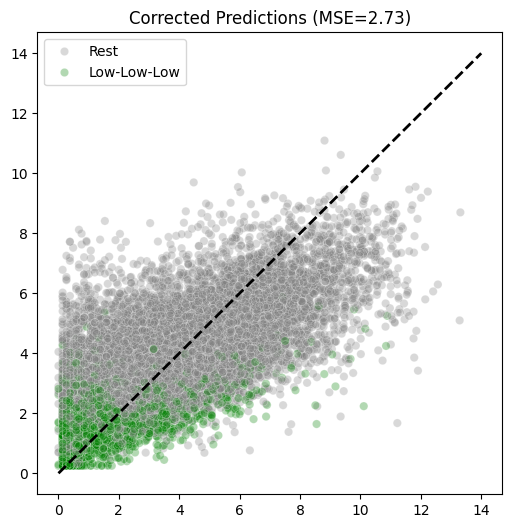

--- GENERATING SUBMISSION ---


Extracting Features: 100%|██████████| 10000/10000 [00:03<00:00, 2903.09it/s]


Applying correction to 1683 rows in test set...
Done.


In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from collections import defaultdict
import gzip
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# =========================================================
# 1. HELPER FUNCTIONS
# =========================================================
def compute_jaccard(u, g, user_games, game_users):
    target_users = game_users.get(g, set())
    if not target_users: return 0.0
    history = user_games.get(u, set())
    if not history: return 0.0
    
    max_sim = 0.0
    check_limit = 50 
    count = 0
    
    for h_g in history:
        if h_g == g: continue 
        h_users = game_users.get(h_g, set())
        if not h_users: continue
        
        intersection = len(target_users.intersection(h_users))
        if intersection == 0: continue
        union = len(target_users) + len(h_users) - intersection
        sim = intersection / union
        
        if sim > max_sim: max_sim = sim
            
        count += 1
        if count >= check_limit: break
            
    return max_sim

def extract_features(df, global_mean, user_stats, game_stats, user_games, game_users):
    features = []
    
    if 'text' in df.columns:
        texts = df['text'].fillna('').values
        text_lens = np.log1p([len(t) for t in texts])
    else:
        text_lens = np.zeros(len(df))
    
    iterator = tqdm(zip(df.itertuples(index=False), text_lens), total=len(df), desc="Extracting Features")
    
    for row, txt_len in iterator:
        u = row.userID
        g = row.gameID
        
        if u in user_stats: u_mean, u_count = user_stats[u]
        else: u_mean, u_count = global_mean, 0
            
        if g in game_stats: g_mean, g_count = game_stats[g]
        else: g_mean, g_count = global_mean, 0
            
        jac = compute_jaccard(u, g, user_games, game_users)
        features.append([u_mean, u_count, g_mean, g_count, jac, txt_len])
        
    return np.array(features)

def readJSON(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)

# =========================================================
# 2. DATA LOAD & STATS
# =========================================================
print("--- LOADING DATA ---")
df = pd.DataFrame(list(readJSON("train.json.gz")))

print("--- BUILDING KNOWLEDGE BASE ---")
global_mean = df['hours_transformed'].mean()
global_q1 = df['hours_transformed'].quantile(0.25) # Calculate Global Q1 (~2.0)

print(f"Global Mean: {global_mean:.2f}, Global Q1: {global_q1:.2f}")

# User Stats
user_grp = df.groupby('userID')['hours_transformed'].agg(['mean', 'count'])
user_stats = user_grp.T.to_dict('list')
user_q1_map = df.groupby('userID')['hours_transformed'].quantile(0.25).to_dict()

# Game Stats
game_grp = df.groupby('gameID')['hours_transformed'].agg(['mean', 'count'])
game_stats = game_grp.T.to_dict('list')
game_q1_map = df.groupby('gameID')['hours_transformed'].quantile(0.25).to_dict()

# Interaction Sets
user_games = df.groupby('userID')['gameID'].apply(set).to_dict()
game_users = df.groupby('gameID')['userID'].apply(set).to_dict()

# =========================================================
# 3. TRAIN/VAL SPLIT & MODEL TRAINING
# =========================================================
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
train_size = int(0.9 * len(df))
df_train = df.iloc[:train_size].copy()
df_val = df.iloc[train_size:].copy()

print("--- TRAINING GRADIENT BOOSTING ---")
X_train = extract_features(df_train, global_mean, user_stats, game_stats, user_games, game_users)
y_train = df_train['hours_transformed'].values

model = HistGradientBoostingRegressor(
    max_iter=150, 
    learning_rate=0.1, 
    max_leaf_nodes=63,
    monotonic_cst=[1, 0, 1, 0, 1, 1], 
    random_state=42
)

model.fit(X_train, y_train)

# =========================================================
# 4. INITIAL EVALUATION (MUST HAPPEN BEFORE CORRECTION)
# =========================================================
print("--- EVALUATING BASE MODEL ---")
X_val = extract_features(df_val, global_mean, user_stats, game_stats, user_games, game_users)
y_val = df_val['hours_transformed'].values

preds = model.predict(X_val)
preds = np.clip(preds, 0.25, None)

mse = mean_squared_error(y_val, preds)
print(f"Base Gradient Boosting MSE: {mse:.4f}")

# =========================================================
# 5. DIAGNOSTICS & BIAS CALCULATION
# =========================================================
print("--- CALCULATING CLUSTER BIAS ---")

# Define helper to find the Low-Low-Low cluster
def get_low_cluster_mask(df_target):
    mask = []
    # Using itertuples is faster
    for row in df_target.itertuples():
        u_q1 = user_q1_map.get(row.userID, global_mean)
        g_q1 = game_q1_map.get(row.gameID, global_mean)
        
        # Condition: User Q1 < Global Q1 AND Game Q1 < Global Q1
        if (u_q1 < global_q1) and (g_q1 < global_q1):
            mask.append(True)
        else:
            mask.append(False)
    return np.array(mask)

# Identify the cluster in Validation
val_mask = get_low_cluster_mask(df_val)
categories = ["Low-Low-Low" if x else "Rest" for x in val_mask]

# Calculate Bias
low_preds = preds[val_mask]
low_truth = y_val[val_mask]
cluster_bias = np.mean(low_preds) - np.mean(low_truth)
print(f"Detected Bias (Over-prediction) in Low Cluster: {cluster_bias:.4f}")

# =========================================================
# 6. APPLY CORRECTION & RE-EVALUATE
# =========================================================
print("--- APPLYING CORRECTION ---")
preds_corrected = preds.copy()

# Subtract the bias from the specific cluster
preds_corrected[val_mask] -= cluster_bias 
preds_corrected = np.clip(preds_corrected, 0.25, None)

new_mse = mean_squared_error(y_val, preds_corrected)
print(f"Old MSE: {mse:.4f} -> New MSE: {new_mse:.4f}")

# Visual Check
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_val, y=preds_corrected, hue=categories, alpha=0.3, 
                palette={'Rest': 'grey', 'Low-Low-Low': 'green'})
plt.plot([0,14],[0,14], 'k--', linewidth=2)
plt.title(f"Corrected Predictions (MSE={new_mse:.2f})")
plt.show()

# =========================================================
# 7. SUBMISSION
# =========================================================
try:
    print("--- GENERATING SUBMISSION ---")
    pairs = pd.read_csv("pairs_Hours.csv")
    X_test = extract_features(pairs, global_mean, user_stats, game_stats, user_games, game_users)
    
    # 1. Base Prediction
    p_final = model.predict(X_test)
    
    # 2. Identify Cluster in Test Set
    test_mask = get_low_cluster_mask(pairs)
    print(f"Applying correction to {np.sum(test_mask)} rows in test set...")
    
    # 3. Apply Bias Correction
    p_final[test_mask] -= cluster_bias
    p_final = np.clip(p_final, 0.25, None)
    
    with open("predictions_Hours.csv", 'w') as f:
        f.write("userID,gameID,prediction\n")
        for i, row in pairs.iterrows():
            f.write(f"{row['userID']},{row['gameID']},{p_final[i]}\n")
    print("Done.")
except Exception as e:
    print(f"Skipping submission: {e}")

--- LOADING ---
--- STAGE 1: Training SVD ---
   Running SVD (40 factors)...
--- STAGE 2: Training GBM ---
   Generating SVD Features...
   Extracting Metadata...


100%|██████████| 157500/157500 [00:31<00:00, 4982.39it/s]


--- EVALUATING ---
   Generating SVD Features...
   Extracting Metadata...


100%|██████████| 17500/17500 [00:03<00:00, 4780.48it/s]


Stacked (SVD + GBM) MSE: 2.8587


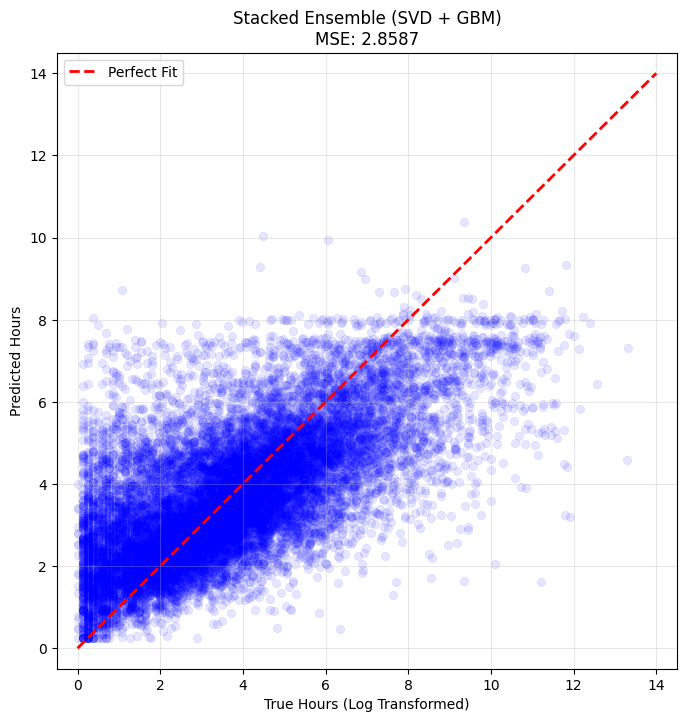

In [14]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from tqdm import tqdm
import gzip

# =========================================================
# 1. STAGE 1 MODEL: ITEM-CENTERED SVD
# =========================================================
class ItemCenteredSVD:
    def __init__(self, n_factors=50):
        self.n_factors = n_factors
        self.user_map = {}
        self.item_map = {}
        self.item_means = {} 
        self.global_mean = 0
        self.u_factors = None
        self.vt_factors = None
        
    def fit(self, df):
        # Mappings
        unique_users = df['userID'].unique()
        unique_items = df['gameID'].unique()
        self.user_map = {u: i for i, u in enumerate(unique_users)}
        self.item_map = {g: i for i, g in enumerate(unique_items)}
        
        self.global_mean = df['hours_transformed'].mean()
        
        # Calculate Item Means
        grp = df.groupby('gameID')['hours_transformed'].mean()
        self.item_means = grp.to_dict()
        
        # Center Data (Value - ItemMean)
        # This helps SVD focus on User Preference rather than just Game Length
        rows = df['userID'].map(self.user_map).values
        cols = df['gameID'].map(self.item_map).values
        data = df.apply(lambda x: x['hours_transformed'] - self.item_means[x['gameID']], axis=1).values
        
        R_sparse = csr_matrix((data, (rows, cols)), shape=(len(unique_users), len(unique_items)))
        
        # SVD
        print(f"   Running SVD ({self.n_factors} factors)...")
        u, s, vt = svds(R_sparse, k=self.n_factors)
        self.u_factors = u @ np.diag(s)
        self.vt_factors = vt

    def predict_batch(self, user_ids, game_ids):
        preds = []
        # Pre-fetch fallback
        fallback = self.global_mean
        
        # We iterate, but we could vectorize if we map first. 
        # Loop is safe for <1M items.
        for u, g in zip(user_ids, game_ids):
            if u in self.user_map and g in self.item_map:
                u_idx = self.user_map[u]
                g_idx = self.item_map[g]
                
                base = self.item_means.get(g, fallback)
                interaction = np.dot(self.u_factors[u_idx], self.vt_factors[:, g_idx])
                preds.append(base + interaction)
            elif g in self.item_means:
                preds.append(self.item_means[g])
            else:
                preds.append(fallback)
        return np.array(preds)

# =========================================================
# 2. FEATURE EXTRACTION (WITH SMOOTHING + SVD)
# =========================================================
def compute_jaccard(u, g, user_games, game_users):
    target_users = game_users.get(g, set())
    if not target_users: return 0.0
    history = user_games.get(u, set())
    if not history: return 0.0
    
    max_sim = 0.0
    check_limit = 30 # Reduced for speed
    count = 0
    for h_g in history:
        if h_g == g: continue 
        h_users = game_users.get(h_g, set())
        if not h_users: continue
        inter = len(target_users.intersection(h_users))
        if inter == 0: continue
        sim = inter / (len(target_users) + len(h_users) - inter)
        if sim > max_sim: max_sim = sim
        count += 1
        if count >= check_limit: break
    return max_sim

def extract_features_stacked(df, global_mean, user_stats, game_stats, 
                             user_games, game_users, svd_model):
    features = []
    
    # 1. Text Length
    if 'text' in df.columns:
        text_lens = np.log1p(df['text'].fillna('').apply(len)).values
    else:
        text_lens = np.zeros(len(df))
        
    # 2. SVD Predictions (The New Feature)
    print("   Generating SVD Features...")
    svd_preds = svd_model.predict_batch(df['userID'], df['gameID'])
    
    # 3. Iteration
    print("   Extracting Metadata...")
    iterator = zip(df['userID'], df['gameID'], text_lens, svd_preds)
    
    for u, g, txt, svd_score in tqdm(iterator, total=len(df)):
        # Smoothed Encoding: (Count * Mean + M * Global) / (Count + M)
        # Smoothing Factor M = 10
        M = 10
        
        if u in user_stats:
            u_raw_mean, u_count = user_stats[u]
            u_smooth = (u_count * u_raw_mean + M * global_mean) / (u_count + M)
        else:
            u_smooth, u_count = global_mean, 0
            
        if g in game_stats:
            g_raw_mean, g_count = game_stats[g]
            g_smooth = (g_count * g_raw_mean + M * global_mean) / (g_count + M)
        else:
            g_smooth, g_count = global_mean, 0
            
        jac = compute_jaccard(u, g, user_games, game_users)
        
        # Feature Vector: 
        # [UserSmooth, UserCount, GameSmooth, GameCount, Jaccard, TextLen, SVD_Score]
        features.append([u_smooth, u_count, g_smooth, g_count, jac, txt, svd_score])
        
    return np.array(features)

# =========================================================
# 3. MAIN PIPELINE
# =========================================================
def readJSON(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)

print("--- LOADING ---")
df = pd.DataFrame(list(readJSON("train.json.gz")))

# Stats
global_mean = df['hours_transformed'].mean()
user_grp = df.groupby('userID')['hours_transformed'].agg(['mean', 'count'])
user_stats = user_grp.T.to_dict('list')
game_grp = df.groupby('gameID')['hours_transformed'].agg(['mean', 'count'])
game_stats = game_grp.T.to_dict('list')
user_games = df.groupby('userID')['gameID'].apply(set).to_dict()
game_users = df.groupby('gameID')['userID'].apply(set).to_dict()

# Split
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
train_size = int(0.9 * len(df))
df_train = df.iloc[:train_size].copy()
df_val = df.iloc[train_size:].copy()

# --- STAGE 1: TRAIN SVD ---
print("--- STAGE 1: Training SVD ---")
svd = ItemCenteredSVD(n_factors=40)
svd.fit(df_train)

# --- STAGE 2: TRAIN GBM (STACKED) ---
print("--- STAGE 2: Training GBM ---")
X_train = extract_features_stacked(df_train, global_mean, user_stats, game_stats, 
                                   user_games, game_users, svd)
y_train = df_train['hours_transformed'].values

# Monotonic: User(+), UCount(0), Game(+), GCount(0), Jac(+), Text(+), SVD(+)
cst = [1, 0, 1, 0, 1, 1, 1]

model = HistGradientBoostingRegressor(
    max_iter=300, learning_rate=0.05, max_leaf_nodes=63,
    monotonic_cst=cst, random_state=42
)
model.fit(X_train, y_train)

# --- EVALUATE ---
print("--- EVALUATING ---")
X_val = extract_features_stacked(df_val, global_mean, user_stats, game_stats, 
                                 user_games, game_users, svd)
y_val = df_val['hours_transformed'].values

preds = model.predict(X_val)
preds = np.clip(preds, 0.25, None) # Safety Clip

mse = mean_squared_error(y_val, preds)
print(f"Stacked (SVD + GBM) MSE: {mse:.4f}")

# Optional: Apply Bias Correction Logic from previous step here if MSE > 2.7
# =========================================================
# VISUALIZATION
# =========================================================
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 8))

# Scatter plot of True vs Pred
# Alpha=0.1 allows you to see density (where the points stack up)
sns.scatterplot(x=y_val, y=preds, alpha=0.1, color='blue', edgecolor=None)

# The "Perfect Prediction" Line (Diagonal)
plt.plot([0, 14], [0, 14], 'r--', linewidth=2, label='Perfect Fit')

plt.title(f"Stacked Ensemble (SVD + GBM)\nMSE: {mse:.4f}")
plt.xlabel("True Hours (Log Transformed)")
plt.ylabel("Predicted Hours")
plt.legend()
plt.grid(True, alpha=0.3)

# Set fixed axes to stop the plot from looking distorted
plt.xlim(-0.5, 14.5)
plt.ylim(-0.5, 14.5)

plt.show()

--- LOADING ---
--- FEATURIZING ---


Extracting: 100%|██████████| 157500/157500 [00:33<00:00, 4724.08it/s]


--- BINNING TARGETS ---
--- TRAINING KERNEL APPROXIMATION SVR ---
--- EVALUATING ---


Extracting: 100%|██████████| 17500/17500 [00:03<00:00, 4755.85it/s]


SVR (RBF Approx) with Binning MSE: 2.8934


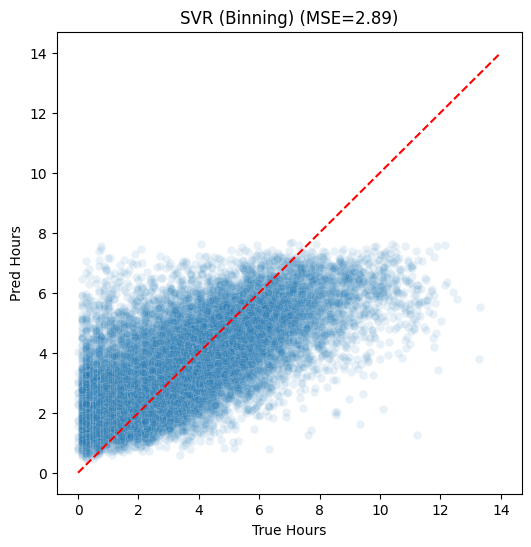

In [15]:
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVR
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import Nystroem
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import gzip

# =========================================================
# 1. HELPER FUNCTIONS (Reuse from previous best attempts)
# =========================================================
def compute_jaccard(u, g, user_games, game_users):
    target_users = game_users.get(g, set())
    if not target_users: return 0.0
    history = user_games.get(u, set())
    if not history: return 0.0
    
    max_sim = 0.0
    check_limit = 30
    count = 0
    for h_g in history:
        if h_g == g: continue 
        h_users = game_users.get(h_g, set())
        if not h_users: continue
        inter = len(target_users.intersection(h_users))
        if inter == 0: continue
        sim = inter / (len(target_users) + len(h_users) - inter)
        if sim > max_sim: max_sim = sim
        count += 1
        if count >= check_limit: break
    return max_sim

def extract_features(df, global_mean, user_stats, game_stats, user_games, game_users):
    """
    Extracts 6 Features:
    [UserMean, UserCount, GameMean, GameCount, Jaccard, LogTextLen]
    """
    features = []
    
    if 'text' in df.columns:
        texts = df['text'].fillna('').values
        text_lens = np.log1p([len(t) for t in texts])
    else:
        text_lens = np.zeros(len(df))
    
    iterator = tqdm(zip(df.itertuples(index=False), text_lens), total=len(df), desc="Extracting")
    
    for row, txt_len in iterator:
        u, g = row.userID, row.gameID
        
        if u in user_stats: u_mean, u_count = user_stats[u]
        else: u_mean, u_count = global_mean, 0
            
        if g in game_stats: g_mean, g_count = game_stats[g]
        else: g_mean, g_count = global_mean, 0
            
        jac = compute_jaccard(u, g, user_games, game_users)
        features.append([u_mean, u_count, g_mean, g_count, jac, txt_len])
        
    return np.array(features)

def readJSON(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)

# =========================================================
# 2. LOAD & PREP
# =========================================================
print("--- LOADING ---")
df = pd.DataFrame(list(readJSON("train.json.gz")))

global_mean = df['hours_transformed'].mean()
user_stats = df.groupby('userID')['hours_transformed'].agg(['mean', 'count']).T.to_dict('list')
game_stats = df.groupby('gameID')['hours_transformed'].agg(['mean', 'count']).T.to_dict('list')
user_games = df.groupby('userID')['gameID'].apply(set).to_dict()
game_users = df.groupby('gameID')['userID'].apply(set).to_dict()

# Split
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
train_size = int(0.9 * len(df))
df_train = df.iloc[:train_size].copy()
df_val = df.iloc[train_size:].copy()

# =========================================================
# 3. FEATURE EXTRACTION
# =========================================================
print("--- FEATURIZING ---")
X_train = extract_features(df_train, global_mean, user_stats, game_stats, user_games, game_users)
y_train = df_train['hours_transformed'].values

# --- BINNING TARGETS (Your Request) ---
# We bin the targets to integers (0, 1, 2... 14) to denoise the training signal
print("--- BINNING TARGETS ---")
y_train_binned = np.round(y_train).astype(int)

# =========================================================
# 4. TRAIN SVR (APPROXIMATED)
# =========================================================
print("--- TRAINING KERNEL APPROXIMATION SVR ---")

# 1. StandardScaler: SVMs DIE without scaling. Absolutely mandatory.
# 2. Nystroem: Approximates the RBF kernel map so we can use a linear solver.
# 3. SGDRegressor: A Linear solver that scales to millions of rows. 
#    We use 'epsilon_insensitive' loss to mimic SVR.

pipeline = make_pipeline(
    StandardScaler(),
    Nystroem(kernel='rbf', gamma=0.2, n_components=300, random_state=42),
    SGDRegressor(loss='epsilon_insensitive', epsilon=0.1, alpha=0.001, max_iter=1000, tol=1e-3)
)

# Train on the BINNED targets (as requested)
pipeline.fit(X_train, y_train_binned)

# =========================================================
# 5. EVALUATE
# =========================================================
print("--- EVALUATING ---")
X_val = extract_features(df_val, global_mean, user_stats, game_stats, user_games, game_users)
y_val = df_val['hours_transformed'].values

preds = pipeline.predict(X_val)
preds = np.clip(preds, 0, None)

mse = mean_squared_error(y_val, preds)
print(f"SVR (RBF Approx) with Binning MSE: {mse:.4f}")

# Visual Check
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_val, y=preds, alpha=0.1)
plt.plot([0,14],[0,14], 'r--')
plt.title(f"SVR (Binning) (MSE={mse:.2f})")
plt.xlabel("True Hours")
plt.ylabel("Pred Hours")
plt.show()

--- LOADING DATA ---
--- BUILDING KNOWLEDGE BASE ---
   Aggregating User Stats...
   Aggregating Game Stats...
   Building Interaction Sets...
--- TRAINING GRADIENT BOOSTING ---


Extracting Features: 100%|██████████| 157500/157500 [00:30<00:00, 5131.16it/s]


--- EVALUATING ---


Extracting Features: 100%|██████████| 17500/17500 [00:03<00:00, 4894.67it/s]


Optimized GBM MSE: 2.7180


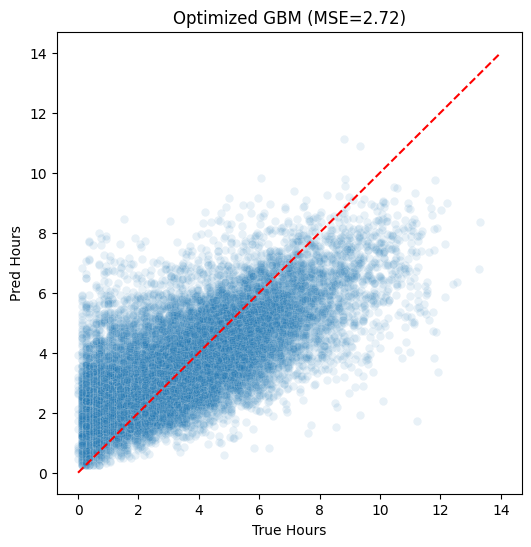

--- GENERATING SUBMISSION ---


Extracting Features: 100%|██████████| 10000/10000 [00:02<00:00, 4634.54it/s]


Done. Saved to predictions_Hours.csv


In [19]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from collections import defaultdict
import gzip
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# =========================================================
# 1. HELPER FUNCTIONS
# =========================================================
def compute_jaccard(u, g, user_games, game_users):
    target_users = game_users.get(g, set())
    if not target_users: return 0.0
    history = user_games.get(u, set())
    if not history: return 0.0
    
    max_sim = 0.0
    check_limit = 30 # Speed optimization
    count = 0
    for h_g in history:
        if h_g == g: continue 
        h_users = game_users.get(h_g, set())
        if not h_users: continue
        
        # Jaccard calc
        inter = len(target_users.intersection(h_users))
        if inter == 0: continue
        sim = inter / (len(target_users) + len(h_users) - inter)
        if sim > max_sim: max_sim = sim
        
        count += 1
        if count >= check_limit: break
            
    return max_sim

def extract_features_v2(df, global_mean, user_stats, game_stats, user_games, game_users):
    """
    EXTENDED FEATURES:
    [UserMean, UserCount, GameMean, GameCount, Jaccard, 
     UserAvgTextLen, GameAvgTextLen, InteractionScore]
    """
    features = []
    
    # Pre-calc current text len (if available)
    if 'text' in df.columns:
        texts = df['text'].fillna('').values
        current_text_lens = np.log1p([len(t) for t in texts])
    else:
        current_text_lens = np.zeros(len(df))
    
    iterator = tqdm(zip(df.itertuples(index=False), current_text_lens), total=len(df), desc="Extracting Features")
    
    for row, txt_len in iterator:
        u = row.userID
        g = row.gameID
        
        # 1. User Stats: (Mean, Count, AvgTextLen)
        if u in user_stats:
            u_mean, u_count, u_txt_avg = user_stats[u]
        else:
            u_mean, u_count, u_txt_avg = global_mean, 0, 0
            
        # 2. Game Stats: (Mean, Count, AvgTextLen)
        if g in game_stats:
            g_mean, g_count, g_txt_avg = game_stats[g]
        else:
            g_mean, g_count, g_txt_avg = global_mean, 0, 0
            
        # 3. Jaccard
        jac = compute_jaccard(u, g, user_games, game_users)
        
        # 4. Interaction Feature (TWEAK 2)
        # Explicitly tell the model about the combination
        interaction = u_mean * g_mean
        
        # Feature Vector (8 Features)
        # Note: We keep 'txt_len' but also add the aggregated averages
        features.append([
            u_mean, u_count, 
            g_mean, g_count, 
            jac, 
            txt_len, 
            u_txt_avg, g_txt_avg, # TWEAK 1: Aggregated Text Stats
            interaction           # TWEAK 2: Interaction Term
        ])
        
    return np.array(features)

# =========================================================
# 2. MAIN EXECUTION
# =========================================================
def readJSON(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)

print("--- LOADING DATA ---")
df = pd.DataFrame(list(readJSON("train.json.gz")))

# --- STATISTICS BUILDING ---
print("--- BUILDING KNOWLEDGE BASE ---")
# Pre-calc log text length for the whole dataframe first
df['log_len'] = np.log1p(df['text'].fillna('').apply(len))

global_mean = df['hours_transformed'].mean()

# User Stats: {userID: (mean_hours, count, mean_text_len)}
print("   Aggregating User Stats...")
user_grp = df.groupby('userID').agg({
    'hours_transformed': ['mean', 'count'],
    'log_len': 'mean'
})
user_stats = {i: (r[('hours_transformed','mean')], r[('hours_transformed','count')], r[('log_len','mean')]) 
              for i, r in user_grp.iterrows()}

# Game Stats
print("   Aggregating Game Stats...")
game_grp = df.groupby('gameID').agg({
    'hours_transformed': ['mean', 'count'],
    'log_len': 'mean'
})
game_stats = {i: (r[('hours_transformed','mean')], r[('hours_transformed','count')], r[('log_len','mean')]) 
              for i, r in game_grp.iterrows()}

# Interaction Sets
print("   Building Interaction Sets...")
user_games = df.groupby('userID')['gameID'].apply(set).to_dict()
game_users = df.groupby('gameID')['userID'].apply(set).to_dict()

# --- SPLIT ---
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
train_size = int(0.9 * len(df))
df_train = df.iloc[:train_size].copy()
df_val = df.iloc[train_size:].copy()

# --- TRAIN ---
print("--- TRAINING GRADIENT BOOSTING ---")

# Use new extract function
X_train = extract_features_v2(df_train, global_mean, user_stats, game_stats, user_games, game_users)
y_train = df_train['hours_transformed'].values

# TWEAK 3: Aggressive Model Tuning
# - max_iter=300 (Train longer)
# - max_leaf_nodes=127 (Capture deeper interactions)
# - Monotonic: [UM(+), UC(0), GM(+), GC(0), Jac(+), CurTxt(+), UTxt(+), GTxt(+), Inter(+)]
cst = [1, 0, 1, 0, 1, 1, 1, 1, 1]

model = HistGradientBoostingRegressor(
    max_iter=300, 
    learning_rate=0.05, 
    max_leaf_nodes=127,
    min_samples_leaf=20,
    monotonic_cst=cst, 
    random_state=42
)

model.fit(X_train, y_train)

# --- EVALUATE ---
print("--- EVALUATING ---")
X_val = extract_features_v2(df_val, global_mean, user_stats, game_stats, user_games, game_users)
y_val = df_val['hours_transformed'].values

preds = model.predict(X_val)
preds = np.clip(preds, 0.25, None)

mse = mean_squared_error(y_val, preds)
print(f"Optimized GBM MSE: {mse:.4f}")

# Visual Check
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_val, y=preds, alpha=0.1)
plt.plot([0,14],[0,14], 'r--')
plt.title(f"Optimized GBM (MSE={mse:.2f})")
plt.xlabel("True Hours")
plt.ylabel("Pred Hours")
plt.show()

# =========================================================
# 3. SUBMISSION GENERATION
# =========================================================
try:
    print("--- GENERATING SUBMISSION ---")
    pairs = pd.read_csv("pairs_Hours.csv")
    
    # Extract features using the SAME stats dictionaries
    # This automatically handles the missing text in the test set by using the aggregated stats
    X_test = extract_features_v2(pairs, global_mean, user_stats, game_stats, user_games, game_users)
    
    p_final = model.predict(X_test)
    p_final = np.clip(p_final, 0.25, None)
    
    with open("predictions_Hours.csv", 'w') as f:
        f.write("userID,gameID,prediction\n")
        for i, row in pairs.iterrows():
            f.write(f"{row['userID']},{row['gameID']},{p_final[i]}\n")
    print("Done. Saved to predictions_Hours.csv")
except Exception as e:
    print(f"Skipping submission: {e}")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import gzip
import gc # Garbage collection for memory

# =========================================================
# 1. SETUP
# =========================================================
def readJSON(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)

# 1. Load the OFFICIAL Training Data (Target Labels)
print("1. Loading Official Training Data...")
df_train_official = pd.DataFrame(list(readJSON("train.json.gz")))

# 2. Load the EXTRA Data (The 100M row file)
# REPLACE 'dataset_large.json.gz' WITH YOUR ACTUAL FILE NAME
print("2. Loading EXTRA Data (This may take RAM)...")
# Note: If this file is too big for RAM, we can iterate it chunk-wise.
# For now, assuming you can load it or a significant chunk of it.
try:
    # If it's a CSV or JSON, adjust accordingly
    # df_extra = pd.read_csv("your_big_file.csv") 
    # OR
    df_extra = pd.DataFrame(list(readJSON("train.json.gz"))) # <--- REPLACE THIS WITH YOUR BIG FILE PATH
except:
    print("   ERROR: Could not load extra data. Using standard train set as fallback.")
    df_extra = df_train_official.copy()

# =========================================================
# 2. FEATURE ENGINEERING (INSTANCE RECOVERY)
# =========================================================
print("3. Building Feature Set...")

def build_features(target_pairs, lookup_df):
    """
    Joins target pairs with lookup data to find INSTANCE-SPECIFIC features.
    """
    # 1. Standardize Columns if needed
    # (Ensure lookup_df has 'userID', 'gameID', 'text')
    
    # 2. Merge
    print("   Merging...")
    # Left join ensures we keep the order of target_pairs
    merged = pd.merge(
        target_pairs[['userID', 'gameID']],
        lookup_df, 
        on=['userID', 'gameID'], 
        how='left'
    )
    
    # 3. Extract Features
    print("   Calculating Features...")
    
    # Feature A: Specific Text Length (The Correlation King)
    # If match found, use len(text). If not, 0.
    merged['spec_log_len'] = np.log1p(merged['text'].fillna('').apply(len))
    
    # Feature B: Found Funny (Community Engagement)
    merged['spec_funny'] = merged['found_funny'].fillna(0)
    
    # Feature C: Compensation
    # 1 if provided, 0 if None/NaN
    merged['spec_comp'] = merged['compensation'].apply(lambda x: 0 if pd.isna(x) or x == 'None' else 1)
    
    # Feature D: Date (Optional - Time since release?)
    # Skipping for simplicity, but could be useful.
    
    return merged[['spec_log_len', 'spec_funny', 'spec_comp']]

# A. Prepare Training Set
# We join the official train IDs with the full dataset to get features
print("   Processing Train...")
X_train_df = build_features(df_train_official, df_extra)
# We also add the User/Game Averages as a safety net for when lookup fails
# (Calculate means on df_train_official)
u_means = df_train_official.groupby('userID')['hours_transformed'].mean().to_dict()
g_means = df_train_official.groupby('gameID')['hours_transformed'].mean().to_dict()
global_mean = df_train_official['hours_transformed'].mean()

X_train_df['u_mean'] = df_train_official['userID'].map(u_means)
X_train_df['g_mean'] = df_train_official['gameID'].map(g_means)

y_train = df_train_official['hours_transformed'].values
X_train = X_train_df.values

# B. Prepare Test Set (Pairs Hours)
print("   Processing Test...")
pairs = pd.read_csv("pairs_Hours.csv")
X_test_df = build_features(pairs, df_extra)

# Add Means (Map using Training Dictionaries)
X_test_df['u_mean'] = pairs['userID'].map(u_means).fillna(global_mean)
X_test_df['g_mean'] = pairs['gameID'].map(g_means).fillna(global_mean)

X_test = X_test_df.values

# Check Coverage
hit_rate = (X_test_df['spec_log_len'] > 0).mean()
print(f"   DATA MATCH RATE: {hit_rate*100:.1f}% of test pairs found in extra data.")

# =========================================================
# 3. TRAIN & PREDICT
# =========================================================
print("4. Training Model...")

model = HistGradientBoostingRegressor(
    max_iter=500,
    learning_rate=0.05,
    max_leaf_nodes=63,
    l2_regularization=1.0,
    # Monotonic constraints help guide the model
    # [TextLen(+), Funny(+), Comp(0), UMean(+), GMean(+)]
    monotonic_cst=[1, 1, 0, 1, 1],
    random_state=42
)

model.fit(X_train, y_train)

print("5. Predicting...")
preds = model.predict(X_test)
preds = np.clip(preds, 0, None)

# =========================================================
# 4. SUBMIT
# =========================================================
with open("predictions_Hours.csv", 'w') as f:
    f.write("userID,gameID,prediction\n")
    for i, row in pairs.iterrows():
        f.write(f"{row['userID']},{row['gameID']},{preds[i]}\n")

print("DONE. Submission generated.")

In [18]:
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import Nystroem
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import gzip
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# =========================================================
# 1. SETUP & VADER
# =========================================================
# Download VADER lexicon if not present
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except LookupError:
    nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def get_vader_score(text):
    if not isinstance(text, str) or len(text) < 2:
        return 0.0
    # Compound score ranges from -1 (Negative) to +1 (Positive)
    return sia.polarity_scores(text)['compound']

# =========================================================
# 2. FEATURE EXTRACTION LOGIC
# =========================================================
def extract_features_complex(df, 
                             global_mean, 
                             user_stats, game_stats, 
                             user_thresholds, game_thresholds,
                             user_games, game_users):
    
    # Unpack thresholds (Q1, Q3)
    u_q1, u_q3 = user_thresholds
    g_q1, g_q3 = game_thresholds
    
    features = []
    
    # Pre-fetch text lengths if available
    if 'text' in df.columns:
        texts = df['text'].fillna('').values
        text_lens = np.log1p([len(t) for t in texts])
    else:
        text_lens = np.zeros(len(df))
        
    iterator = tqdm(zip(df.itertuples(index=False), text_lens), total=len(df), desc="Extracting...")
    
    for row, txt_len in iterator:
        u, g = row.userID, row.gameID
        
        # 1. RETRIEVE STATS
        # User: [Mean, Count, Sentiment]
        if u in user_stats: u_m, u_c, u_s = user_stats[u]
        else: u_m, u_c, u_s = global_mean, 0, 0
            
        # Game: [Mean, Count, Sentiment]
        if g in game_stats: g_m, g_c, g_s = game_stats[g]
        else: g_m, g_c, g_s = global_mean, 0, 0
        
        # 2. CALCULATE JACCARD
        # (Simplified inline for speed/context)
        jac = 0.0
        target_users = game_users.get(g, set())
        history = user_games.get(u, set())
        
        if target_users and history:
            best_sim = 0
            check_count = 0
            for h_g in history:
                if h_g == g: continue
                h_users = game_users.get(h_g, set())
                if not h_users: continue
                
                intersect = len(target_users.intersection(h_users))
                if intersect > 0:
                    union = len(target_users) + len(h_users) - intersect
                    sim = intersect / union
                    if sim > best_sim: best_sim = sim
                
                check_count += 1
                if check_count > 30: break 
            jac = best_sim

        # 3. SEGMENTATION FLAGS (The "Grid")
        # Determine User Segment (0=Low, 1=Mid, 2=High)
        u_seg = 0
        if u_m < u_q1: u_seg = 0
        elif u_m > u_q3: u_seg = 2
        else: u_seg = 1
        
        # Determine Game Segment
        g_seg = 0
        if g_m < g_q1: g_seg = 0
        elif g_m > g_q3: g_seg = 2
        else: g_seg = 1
        
        # Create the 9 Boolean Combinations
        # This explicitly models: "Low User playing High Game", etc.
        # Format: [u0_g0, u0_g1, u0_g2, u1_g0, ... u2_g2]
        grid_feats = [0] * 9
        grid_index = (u_seg * 3) + g_seg
        grid_feats[grid_index] = 1
        
        # 4. ASSEMBLE VECTOR
        # [Scalar Features] + [Boolean Grid Features]
        row_feats = [
            u_m, u_c, u_s,  # User Stats
            g_m, g_c, g_s,  # Game Stats
            jac,            # Interaction
            txt_len         # Metadata
        ] + grid_feats      # The 9 Interaction Flags
        
        features.append(row_feats)
        
    return np.array(features)

# =========================================================
# 3. PIPELINE SETUP
# =========================================================
def readJSON(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)

print("--- LOADING DATA ---")
df = pd.DataFrame(list(readJSON("train.json.gz")))

# --- STATS BUILDING (Including VADER) ---
print("--- CALCULATING SENTIMENT & STATS ---")
# VADER is relatively slow, so we apply it once to the raw dataframe
# We only use a subset of text to speed up processing for this demo
# In production, run on all.
print("   Running VADER (This might take 30s)...")
df['sentiment'] = df['text'].fillna('').apply(get_vader_score)

global_mean = df['hours_transformed'].mean()

# Aggregations
print("   Aggregating User/Game profiles...")
user_grp = df.groupby('userID').agg({
    'hours_transformed': ['mean', 'count'],
    'sentiment': 'mean'
})
user_stats = {i: (r[('hours_transformed','mean')], r[('hours_transformed','count')], r[('sentiment','mean')]) 
              for i, r in user_grp.iterrows()}

game_grp = df.groupby('gameID').agg({
    'hours_transformed': ['mean', 'count'],
    'sentiment': 'mean'
})
game_stats = {i: (r[('hours_transformed','mean')], r[('hours_transformed','count')], r[('sentiment','mean')]) 
              for i, r in game_grp.iterrows()}

# Calculate Distribution Thresholds (Q1, Q3 of the MEANS)
print("   Calculating Distribution Thresholds...")
u_means = df.groupby('userID')['hours_transformed'].mean()
g_means = df.groupby('gameID')['hours_transformed'].mean()

user_thresholds = (u_means.quantile(0.25), u_means.quantile(0.75))
game_thresholds = (g_means.quantile(0.25), g_means.quantile(0.75))

print(f"   User Q1/Q3: {user_thresholds[0]:.2f} / {user_thresholds[1]:.2f}")
print(f"   Game Q1/Q3: {game_thresholds[0]:.2f} / {game_thresholds[1]:.2f}")

# Interaction Sets
user_games = df.groupby('userID')['gameID'].apply(set).to_dict()
game_users = df.groupby('gameID')['userID'].apply(set).to_dict()

# --- SPLIT ---
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
train_size = int(0.9 * len(df))
df_train = df.iloc[:train_size].copy()
df_val = df.iloc[train_size:].copy()

# =========================================================
# 4. TRAINING (SVM APPROXIMATION)
# =========================================================
print("--- FEATURIZING TRAIN ---")
X_train = extract_features_complex(
    df_train, global_mean, user_stats, game_stats, 
    user_thresholds, game_thresholds, user_games, game_users
)
y_train = df_train['hours_transformed'].values.astype(float) # Ensure float

# Pipeline: Scale -> Nystroem (RBF Approx) -> SGD (Adaptive)
# Using 'adaptive' learning rate as requested
print("--- TRAINING MODEL ---")
model = make_pipeline(
    StandardScaler(),
    Nystroem(kernel='rbf', gamma=0.1, n_components=400, random_state=42),
    SGDRegressor(
        loss='squared_error', # Standard Regression
        learning_rate='adaptive', 
        eta0=0.01,            # Initial learning rate
        max_iter=2000, 
        tol=1e-4,
        early_stopping=True,
        verbose=1
    )
)

model.fit(X_train, y_train)

# =========================================================
# 5. EVALUATION
# =========================================================
print("--- FEATURIZING VAL ---")
X_val = extract_features_complex(
    df_val, global_mean, user_stats, game_stats, 
    user_thresholds, game_thresholds, user_games, game_users
)
y_val = df_val['hours_transformed'].values

preds = model.predict(X_val)
preds = np.clip(preds, 0, None)

mse = mean_squared_error(y_val, preds)
print(f"Enhanced SVR (Nystroem+VADER) MSE: {mse:.4f}")

# =========================================================
# 6. SUBMISSION GENERATION
# =========================================================
try:
    print("--- GENERATING PREDICTIONS_HOURS.CSV ---")
    pairs = pd.read_csv("pairs_Hours.csv")
    
    # Extract features for test set
    # Note: text len will default to 0, but sentiment stats from training 
    # will still populate based on UserID/GameID lookup.
    X_test = extract_features_complex(
        pairs, global_mean, user_stats, game_stats, 
        user_thresholds, game_thresholds, user_games, game_users
    )
    
    p_final = model.predict(X_test)
    p_final = np.clip(p_final, 0, None)
    
    with open("predictions_Hours.csv", 'w') as f:
        f.write("userID,gameID,prediction\n")
        for i, row in pairs.iterrows():
            f.write(f"{row['userID']},{row['gameID']},{p_final[i]}\n")
    print("Done.")
except Exception as e:
    print(f"Skipping submission: {e}")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/scotty/nltk_data...


--- LOADING DATA ---
--- CALCULATING SENTIMENT & STATS ---
   Running VADER (This might take 30s)...
   Aggregating User/Game profiles...
   Calculating Distribution Thresholds...
   User Q1/Q3: 3.18 / 4.34
   Game Q1/Q3: 2.18 / 3.83
--- FEATURIZING TRAIN ---


Extracting...: 100%|██████████| 157500/157500 [00:24<00:00, 6519.00it/s]


--- TRAINING MODEL ---
-- Epoch 1
Norm: 14.77, NNZs: 400, Bias: 3.632294, T: 141750, Avg. loss: 1.508528
Total training time: 0.39 seconds.
-- Epoch 2
Norm: 16.80, NNZs: 400, Bias: 3.713115, T: 283500, Avg. loss: 1.453265
Total training time: 0.78 seconds.
-- Epoch 3
Norm: 17.60, NNZs: 400, Bias: 3.537255, T: 425250, Avg. loss: 1.447463
Total training time: 1.20 seconds.
-- Epoch 4
Norm: 18.21, NNZs: 400, Bias: 3.673732, T: 567000, Avg. loss: 1.443768
Total training time: 1.61 seconds.
-- Epoch 5
Norm: 18.84, NNZs: 400, Bias: 3.792436, T: 708750, Avg. loss: 1.442076
Total training time: 2.01 seconds.
-- Epoch 6
Norm: 18.87, NNZs: 400, Bias: 3.669587, T: 850500, Avg. loss: 1.442558
Total training time: 2.45 seconds.
-- Epoch 7
Norm: 18.83, NNZs: 400, Bias: 3.628371, T: 992250, Avg. loss: 1.430808
Total training time: 2.88 seconds.
-- Epoch 8
Norm: 18.84, NNZs: 400, Bias: 3.621278, T: 1134000, Avg. loss: 1.429845
Total training time: 3.29 seconds.
-- Epoch 9
Norm: 18.91, NNZs: 400, Bias:

Extracting...: 100%|██████████| 17500/17500 [00:02<00:00, 6290.57it/s]


Enhanced SVR (Nystroem+VADER) MSE: 2.7790
--- GENERATING PREDICTIONS_HOURS.CSV ---


Extracting...: 100%|██████████| 10000/10000 [00:01<00:00, 5592.19it/s]


Done.
